In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.gaussian_process.kernels import RBF

from sklearn.decomposition import PCA
from sklearn.svm import SVC

import seaborn as sns

import pandas as pd

In [2]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data

# Show data point's class label
y = iris.target

#X, y = shuffle(X, y, random_state=0)

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [3]:
# Apply PCA
n_comp = 2

pca = make_pipeline(StandardScaler(), PCA(n_components=n_comp, random_state = 1))

# Transform the data into 2 dimensional
X_fit = pca.fit_transform(X)

# Supported vector machine

Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data.

More exampled can be found from this repo: https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb

In [4]:
## Now just consider two classes for simplicity
X_two_cat = X[y != 1]
y_two_cat = y[y != 1]

## Scale the data and throw it into a Pandas df
X_two_cat = pca.fit_transform(X_two_cat)

X_two_cat_df = pd.DataFrame({"pc_1": X_two_cat[:,0], "pc_2": X_two_cat[:,1], "label": y_two_cat})

X_two_cat_df['class_label'] = X_two_cat_df['label'].map({0: "setosa", 1: "versicolor", 2:"virginica"})
X_two_cat_df

,pc_1,pc_2,label,class_label
0,-1.754961,-0.211935,0,setosa
1,-1.485435,0.969455,0,setosa
2,-1.774531,0.617818,0,setosa
3,-1.699099,0.872568,0,setosa
4,-1.885876,-0.389434,0,setosa
...,...,...,...,...
95,1.819876,-0.095443,2,virginica
96,1.681223,1.211206,2,virginica
97,1.527136,0.014454,2,virginica
98,1.295739,-0.770170,2,virginica


In [5]:
## Apply SVM on PCA transformed data
def plot_binary_svc_decision_boundary(svm_clf, data_df, show_decision_val=False):
    """Plot the decision boundary for the binary classification."""

    # get the separating hyperplane. It's a one-dimension affine subspace (line) for binary classification.
    # For binary classification, w is the direction of the decision boundary. svm_clf.coef_[0] == svm_clf.coef_
    w = svm_clf.coef_[0] 
    # For binary classification, b is the intercept of the decision boundary. svm_clf.intercept_[0] == svm_clf.intercept_
    b = svm_clf.intercept_[0] 
    
    # At the decision boundary (hyperplane), <w,x> + b = 0. i.e., w @ x + b = 0
    # For the linear decision boundary, this turns: w0 * x0 + w1 * x1 + b = 0
    # Thus, x1 = (-w0 * x0  - b)/w1
    xx = np.linspace(-4, 4)
    yy = (-w[0] * xx  - b)/w[1]
    
    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in 2-d.
    a = -w[0] / w[1]
    margin = 1 / np.sqrt(np.sum(svm_clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin
    
    plt.figure(1, figsize=(12, 8))
    plt.clf()
    plt.plot(xx, yy, "k-", label = "decision boundary")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")
    
    hue_order = ["setosa", "versicolor", "virginica"]
    
    plt.scatter(
        svm_clf.support_vectors_[:, 0],
        svm_clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        cmap=cm.get_cmap("RdBu"),
    )

    sns.set_context("notebook")
    sns.set_style("ticks")
    sns.scatterplot(data=data_df, 
                    x="pc_1", 
                    y="pc_2", 
                    hue="class_label",
                    palette="deep",
                    hue_order = hue_order,
                    legend=True,
                    s = 100,
                    alpha = 0.5)
    sns.despine()
    
    x_min, x_max = -4, 4 # Set the x and y limit for the plot
    y_min, y_max = -4, 4    
    
    if show_decision_val == True:
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = svm_clf.decision_function(xy).reshape(XX.shape)
        levels = np.linspace(-5, 5, 21)
        plt.contourf(XX, YY, Z, levels=levels, cmap=cm.get_cmap("coolwarm"), 
                     alpha=0.3, linestyles=["-"])
        cbar = plt.colorbar(orientation="horizontal")
        cbar.set_label('Distance from decision boundary', rotation=0)
    
    plt.axis("tight")
    plt.title("Plot of decision boundary")
    plt.xlabel("first PC")
    plt.ylabel("second PC")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
    plt.show()

In svm.SVC: The strength of the regularization is inversely proportional to C. Lower C leads to stronger regulariztion, and more generalized error
Decision boundary for penalty C= 0.01


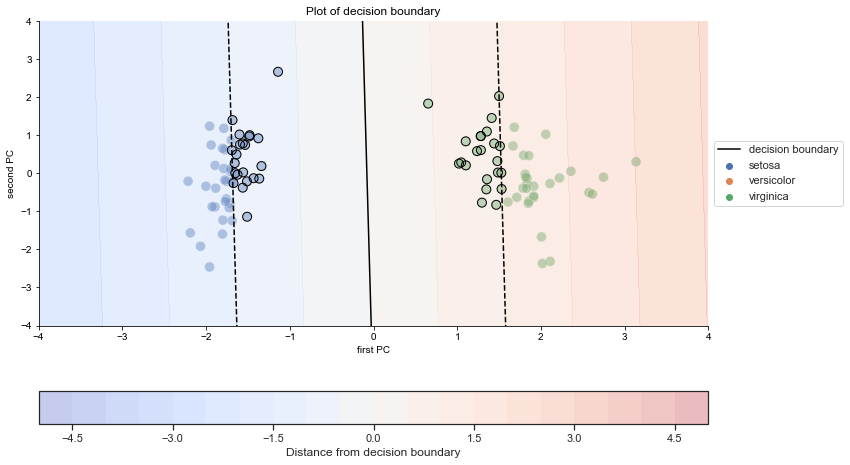

Decision boundary for penalty C= 0.1


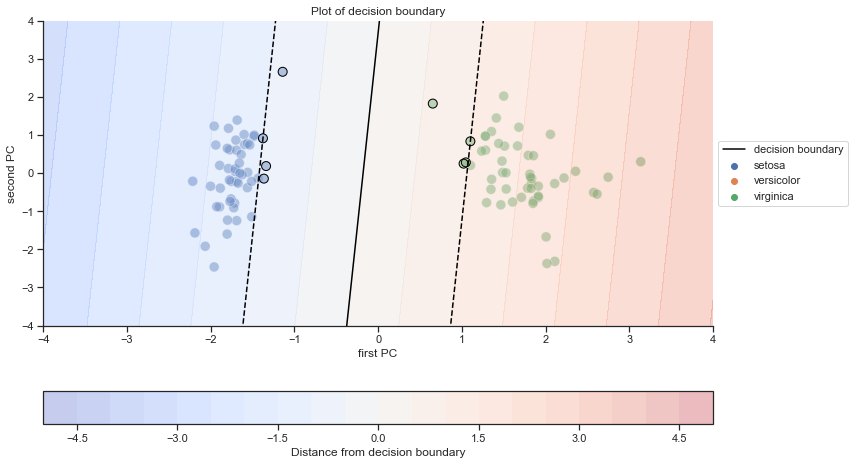

Decision boundary for penalty C= 1


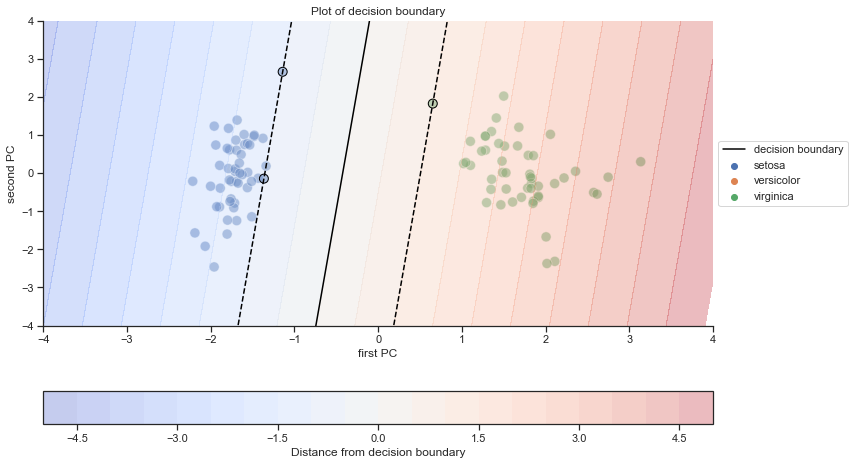

In [6]:
## SVM Classifier model
print("In svm.SVC: The strength of the regularization is inversely proportional to C. Lower C leads to stronger regulariztion, and more generalized error")
for penalty in [0.01, 0.1, 1]:
    svm_clf = SVC(kernel="linear", C=penalty)
    svm_clf.fit(X_two_cat, y_two_cat)
    print("Decision boundary for penalty C=", penalty)
    plot_binary_svc_decision_boundary(svm_clf,X_two_cat_df, show_decision_val=True)   

# Linear classifier SVM with SGD training
alpha in SGDClassifier: Constant that multiplies the regularization term. The higher the value, the stronger the regularization.

In comparison, in svm.SVC: The strength of the regularization is inversely proportional to C.

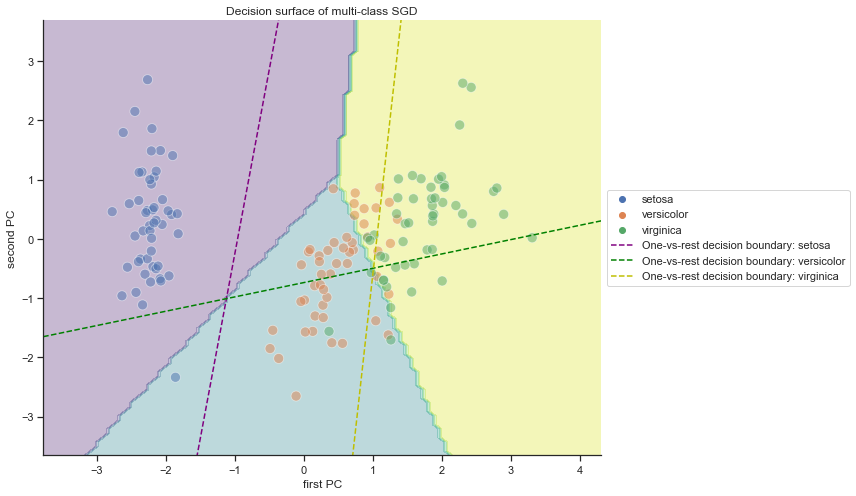

In [7]:
## Define the classifier: Linear classifiers (SVM) with SGD training.
clf = SGDClassifier(alpha=0.01, max_iter=100, random_state = 1).fit(X_fit, y)

plt.figure(figsize =(10, 8))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_fit,
    cmap='viridis',
    alpha=0.3,
    ax=ax,
    response_method="predict",
    xlabel="first PC",
    ylabel="second PC",
)
plt.axis("tight")

## Plot also the training points

X_fit_df = pd.DataFrame({"pc_1": X_fit[:,0], "pc_2": X_fit[:,1], "label": y})

X_fit_df['class_label'] = X_fit_df['label'].map({0: "setosa", 1: "versicolor", 2:"virginica"})

hue_order = ["setosa", "versicolor", "virginica"]


sns.set_context("notebook")
sns.set_style("ticks")
sns.scatterplot(data=X_fit_df, 
                x="pc_1", 
                y="pc_2", 
                hue="class_label",
                palette="deep",
                hue_order = hue_order,
                legend=True,
                s = 100,
                alpha = 0.5)
sns.despine()

plt.axis("tight")

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_


def plot_hyperplane(c, color, class_name):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1] # return the binary decision boundary
    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color, label=f"One-vs-rest decision boundary: {class_name}")


    
class_names = ["setosa", "versicolor", "virginica"]
line_colors = ["purple", "g", "y"]

for class_name, i, color in zip(class_names, clf.classes_, line_colors):
    plot_hyperplane(i, color, class_name)

plt.title("Decision surface of multi-class SGD")
plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.show()

# Kernel Trick

More to read: https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f

In [60]:
## Create sample dataset
n_samples = 800
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X_1, y_1 = noisy_circles

Text(0.5, 1.0, 'Original Feature Space')

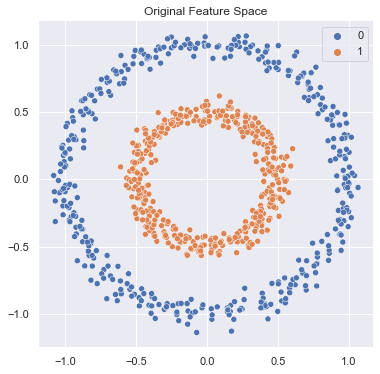

In [61]:
## Plot original data
plt.figure(figsize=(6,6))
sns.scatterplot(x=X_1[:,0], y=X_1[:,1], hue=y_1)
sns.despine()
plt.title("Original Feature Space")

In [68]:
def poly_2(x):
    """Apply 2-degree polynomial on the original data"""
    return np.sum(x**2, axis=1) + 2 * np.prod(x, axis = 1)


def poly_2_kernel(x, y):
    """Compute the 2-degree polynomial kernel. at Gamma=1, and coef0=0
    k(x,y) = np.dot(phi(x), phi(y)) = (x.T @ y)^2 
    more generally, K(X, Y) = (gamma <X, Y> + coef0)^degree """
    return np.power(np.dot(x, y.T), 2)

def gaussian(x, l):
    """Apply gaussina on the original data.
    It is parameterized by a length scale
    parameter l. """
    
    # Generate Z component, using "from sklearn.gaussian_process.kernels import RBF"
    # The feature map function phi: https://en.wikipedia.org/wiki/Radial_basis_function_kernel
    z = RBF(l).__call__(x)[0] 
    return z


def check_spd(gram_mat):
    ## Check symmetry
    if (gram_mat == gram_mat.T).all():
        print("Gram_mat is Symmetric")

    ## Check positive semidefinite
    if np.all(np.linalg.eigvals(gram_mat) > 0) == False:
        print("Gram_mat is positive semidefinite")
        
        


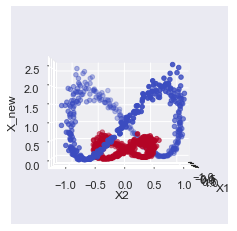

Shape of Gram matrix: (800, 800)
Gram_mat is Symmetric
Gram_mat is positive semidefinite


In [75]:

X_new_poly = poly_2(X_1)

## Plot the new feature space of 2-d polynomial
def plot_3d(X_new):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X_new")

    ax.scatter(X_1[:,0], X_1[:,1], X_new, c=y_1, cmap = "coolwarm")
    ax.view_init(0, 0)

    plt.show()
    
plot_3d(X_new_poly)

## Apply 2-degree polynomial kernel on the original feature space
Gram_mat_poly = poly_2_kernel(X_1, X_1)
print("Shape of Gram matrix:",Gram_mat_poly.shape)

check_spd(Gram_mat_poly)


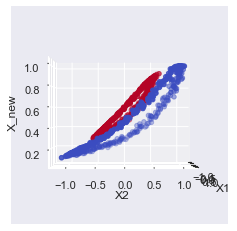

In [76]:
X_new_rbf = gaussian(X_1, 1.0)

plot_3d(X_new_rbf)

In [8]:
A = np.array([0.22536459,-0.61034291])
# A[0], A[1]
A_copy = A.copy()

In [87]:
B = np.random.randn(2,1)
print(B)

[[ 0.22536459]
 [-0.61034291]]


In [7]:
list(range(1,1001))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185